[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pronobis/libspn-keras/blob/master/examples/notebooks/Sampling%20with%20conv%20SPNs.ipynb)

# **Image Sampling**: Sampling MNIST images
In this notebook, we'll set up an SPN to generate new MNIST images by sampling from an SPN.

First let's set up the dependencies:

In [11]:
!pip install libspn-keras matplotlib

## Convolutional SPN
A convolutional SPN consists of convolutional product and convolutional sum nodes. For the sake of 
demonstration, we'll use a structure that trains relatively quickly, without worrying too much about the final performance of the model. 

In [12]:
import libspn_keras as spnk

### Setting the Default Sum Accumulator Initializer

In `libspn-keras`, we refer to the unnormalized weights as _accumulators_. These can be represented in linear space or logspace. Setting the ``SumOp`` also configures the default choice of representation space for these accumulators. For example, gradients should be used in the case of _discriminative_ learning and accumulators are then preferrably represented in logspace. This overcomes the need to project the accumulators to $\mathbb R^+$ after gradient updates, since for log accumulators can take any value in $\mathbb R$ (whereas linear accumulators are limited to $\mathbb R^+$).

In this case however, we'll do generative learning so we can set our `SumOp` to `SumOpEMBackprop`.

To set the default initial value (which will be transformed to logspace internally if needed), one can use `spnk.set_default_accumulator_initializer`:

In [13]:
from tensorflow import keras

spnk.set_default_accumulator_initializer(
    spnk.initializers.Dirichlet()
)

In [14]:
import numpy as np
import tensorflow_datasets as tfds
from libspn_keras.layers import NormalizeAxes
import tensorflow as tf

def take_first(a, b):
  return tf.reshape(tf.cast(a, tf.float32), (-1, 28, 28, 1))

normalize = spnk.layers.NormalizeStandardScore(
    input_shape=(28, 28, 1), axes=NormalizeAxes.GLOBAL, 
    normalization_epsilon=1e-3
)

mnist_images = tfds.load(name="mnist", batch_size=32, split="train", as_supervised=True).map(take_first)
normalize.adapt(mnist_images) 
mnist_normalized = mnist_images.map(normalize)
location_initializer = spnk.initializers.PoonDomingosMeanOfQuantileSplit(
    mnist_normalized
)

### Defining the Architecture
We'll go for a relatively simple convolutional SPN architecture. We use solely non-overlapping patches. After 5 convolutions, the nodes' scopes cover all variables. We then add a layer with 10 mixtures, one for each class. We can do this to optimize the joint probability of $P(X,Y)$ instead of just $P(X)$.

In [15]:
def build_spn(sum_op, return_logits, infer_no_evidence=False):
  spnk.set_default_sum_op(sum_op)
  return spnk.models.SequentialSumProductNetwork([
     spnk.layers.NormalizeStandardScore(input_shape=(28, 28, 1)),
  spnk.layers.NormalLeaf(
      num_components=16,
      location_trainable=True,
      location_initializer=keras.initializers.TruncatedNormal(
          stddev=1.0, mean=0.0)
  ),
  # Non-overlapping products
  spnk.layers.Conv2DProduct(
      depthwise=True,
      strides=[2, 2],
      dilations=[1, 1],
      kernel_size=[2, 2],
      padding='valid'
  ),
  spnk.layers.Local2DSum(num_sums=16),
  # Non-overlapping products
  spnk.layers.Conv2DProduct(
      depthwise=True,
      strides=[2, 2],
      dilations=[1, 1],
      kernel_size=[2, 2],
      padding='valid'
  ),
  spnk.layers.Local2DSum(num_sums=32),
  # Overlapping products, starting at dilations [1, 1]
  spnk.layers.Conv2DProduct(
      depthwise=True,
      strides=[1, 1],
      dilations=[1, 1],
      kernel_size=[2, 2],
      padding='full'
  ),
  spnk.layers.Local2DSum(num_sums=32),
  # Overlapping products, with dilations [2, 2] and full padding
  spnk.layers.Conv2DProduct(
      depthwise=True,
      strides=[1, 1],
      dilations=[2, 2],
      kernel_size=[2, 2],
      padding='full'
  ),
  spnk.layers.Local2DSum(num_sums=64),
  # Overlapping products, with dilations [2, 2] and full padding
  spnk.layers.Conv2DProduct(
      depthwise=True,
      strides=[1, 1],
      dilations=[4, 4],
      kernel_size=[2, 2],
      padding='full'
  ),
  spnk.layers.Local2DSum(num_sums=64),
  # Overlapping products, with dilations [2, 2] and 'final' padding to combine
  # all scopes
  spnk.layers.Conv2DProduct(
      depthwise=True,
      strides=[1, 1],
      dilations=[8, 8],
      kernel_size=[3, 2],
      padding='final'
  ),
  spnk.layers.SpatialToRegions(),
  # Class roots
  spnk.layers.DenseSum(num_sums=10),
  spnk.layers.RootSum(return_weighted_child_logits=return_logits)
  ], infer_no_evidence=infer_no_evidence, unsupervised=False)
 

In [16]:
sum_product_network = build_spn(spnk.SumOpEMBackprop(), return_logits=True)
sum_product_network.summary()

Model: "sequential_sum_product_network_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize_standard_score_4 ( (None, 28, 28, 1)         0         
_________________________________________________________________
normal_leaf_2 (NormalLeaf)   (None, 28, 28, 16)        25088     
_________________________________________________________________
conv2d_product_12 (Conv2DPro (None, 14, 14, 16)        4         
_________________________________________________________________
local2d_sum_10 (Local2DSum)  (None, 14, 14, 16)        50176     
_________________________________________________________________
conv2d_product_13 (Conv2DPro (None, 7, 7, 16)          4         
_________________________________________________________________
local2d_sum_11 (Local2DSum)  (None, 7, 7, 32)          25088     
_________________________________________________________________
conv2d_product_14 (Conv2DPro (None

### Setting up a `tf.Dataset` with `tensorflow_datasets`
Then, we'll configure a train set and a test set using `tensorflow_datasets`.

In [17]:
import tensorflow_datasets as tfds

batch_size = 128

mnist_train = (
    tfds.load(name="mnist", split="train", as_supervised=True)
    .shuffle(1024)
    .batch(batch_size)
)

mnist_test = (
    tfds.load(name="mnist", split="test", as_supervised=True)
    .batch(100)
)

### Configuring the remaining training components
Note that our SPN spits out the joint probabities for each $y\in\{Y_i\}_{i=1}^{10}$, so there are 10 outputs per sample. We can optimize the probability of $P(X,Y)$ by using `spnk.metrics.NegativeLogJoint` as the loss.

In [18]:
optimizer = spnk.optimizers.OnlineExpectationMaximization(learning_rate=0.05, accumulate_batches=1)
metrics = []
loss = spnk.losses.NegativeLogJoint()

sum_product_network.compile(loss=loss, metrics=metrics, optimizer=optimizer)

### Training the SPN
We can simply use the `.fit` function that comes with Keras and pass our `tf.data.Dataset` to it to train!

In [19]:
import tensorflow as tf 

sum_product_network.fit(mnist_train, epochs=20, callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", min_delta=0.1, patience=2, factor=0.5)])
sum_product_network.evaluate(mnist_test)

Epoch 1/20
469/469 [==============================] - 10s 17ms/step - loss: 1031.4774
Epoch 2/20
469/469 [==============================] - 6s 12ms/step - loss: 992.1619
Epoch 3/20
469/469 [==============================] - 6s 12ms/step - loss: 987.2701
Epoch 4/20
469/469 [==============================] - 6s 12ms/step - loss: 985.6664
Epoch 5/20
469/469 [==============================] - 6s 13ms/step - loss: 984.7069
Epoch 6/20
469/469 [==============================] - 6s 12ms/step - loss: 984.0159
Epoch 7/20
469/469 [==============================] - 6s 12ms/step - loss: 983.6499
Epoch 8/20
469/469 [==============================] - 6s 12ms/step - loss: 983.3379
Epoch 9/20
469/469 [==============================] - 6s 12ms/step - loss: 983.0560
Epoch 10/20
469/469 [==============================] - 6s 12ms/step - loss: 982.8787
Epoch 11/20
469/469 [==============================] - 6s 12ms/step - loss: 982.6745
Epoch 12/20
469/469 [==============================] - 6s 12ms/step - lo

980.3607788085938

## Building an SPN to sample
For sampling, we require our sum nodes to backpropagate discrete signals that correspond to the sampled paths. Each
path originates at the root and eventually ends up at the leaves. We can set the backprop op to
`spnk.SumOpSampleBackprop` to ensure all sum layers propagate the discrete sample signal.

We build using the same function as before and copy the weights from the already trained SPN.

In [20]:
sum_product_network_sample = build_spn(spnk.SumOpSampleBackprop(), return_logits=False, infer_no_evidence=True)
sum_product_network_sample.set_weights(sum_product_network.get_weights())

## Drawing samples
Sampling from SPNs comes down to determining values for variables that are outside of the evidence. When images are
sampled as a whole, all variables are omitted from the evidence. For this special case of inference,
the `SequentialSumProductNetwork` class defines a `zero_evidence_inference` method that takes a size parameter.

Below, we sample 64 images and voilá!

Sampling done... Now ploting results


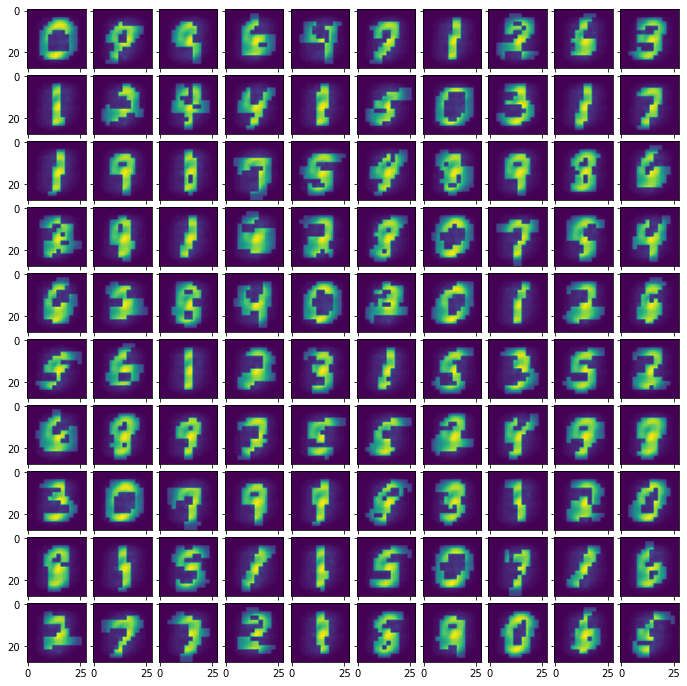

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(10, 10),
    axes_pad=0.1,
)

sample = sum_product_network_sample.zero_evidence_inference(100)

print("Sampling done... Now ploting results")
for ax, im in zip(grid, sample):
    ax.imshow(np.squeeze(im))
plt.show()